In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from torchvision import models
from torch.autograd import Variable
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
import torch

In [2]:
from scipy.ndimage.filters import gaussian_filter

In [3]:
resnet = models.resnet34(pretrained=True)

In [4]:
import sys
sys.path.insert(0, '..')
from AttentionModule import Conv2d_Attn


In [5]:
attn_model = torch.load('../5-11-retrain/saved_models/2018_05_11_07:52:37.371781_ffaaabaaabaa_resnet34_l2_full.pth')

/home/ubuntu/miniconda3/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'AttentionModule.Conv2d_Attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [67]:
import torchvision.transforms as transforms
import torchvision
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)

In [70]:
import random
random.shuffle(trainset.imgs)

In [71]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

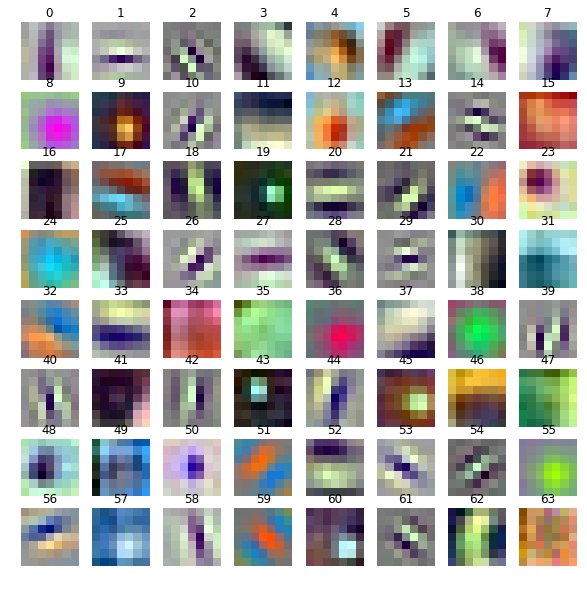

In [132]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    n = resnet.conv1.weight[i].transpose(0,2).data.cpu().numpy()
#     n = (n*(256/2)+(256/2)).astype(int)

    n = (n-n.min())
    n = n/n.max()*255
    n = n.astype(int)
    
    plt.imshow(n)
    plt.title(str(i))
    plt.axis('off')

In [76]:
(attn_model.conv1.attn_weights.squeeze()).sum(1).topk(3)

(Variable containing:
  4.9349
  4.0448
  3.8978
 [torch.cuda.FloatTensor of size 3 (GPU 0)], Variable containing:
  25
  43
  23
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [77]:
to_conv = resnet.conv1

In [78]:
max_iter = 10
all_act = []
for input, _ in trainloader:
    out = to_conv(Variable(input).cuda())
    act = out[:,[25,43,23]]
    all_act.append(act.data)

In [80]:
all_act[0].shape

torch.Size([32, 3, 112, 112])

In [83]:
all_act = torch.cat(all_act)

In [85]:
all_act[0].norm()

299.1888427734375

In [115]:
filt_25 = all_act[:,0,...]

In [123]:
l1_norms = np.array([filt_25[i].norm(p=1) for i in range(8161)])

In [125]:
import PIL

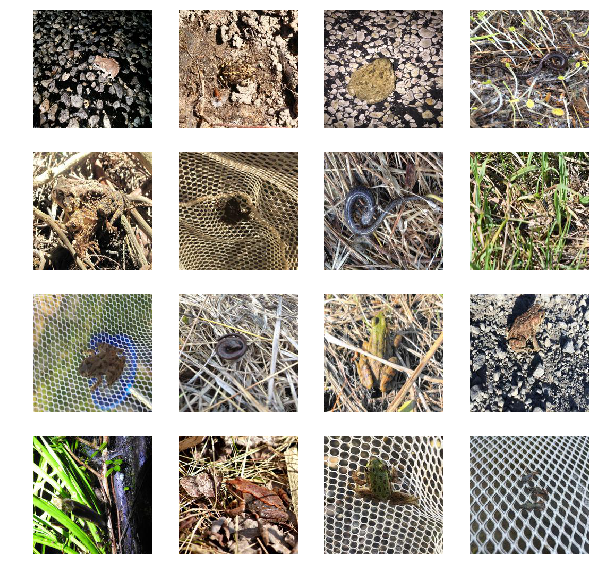

In [126]:
plt.figure(figsize=(10,10))
for i, idx in enumerate(np.argsort(l1_norms)[-16:]):
    plt.subplot(4,4,i+1)
    plt.imshow(PIL.Image.open(trainset.imgs[idx][0]))
    plt.axis('off')

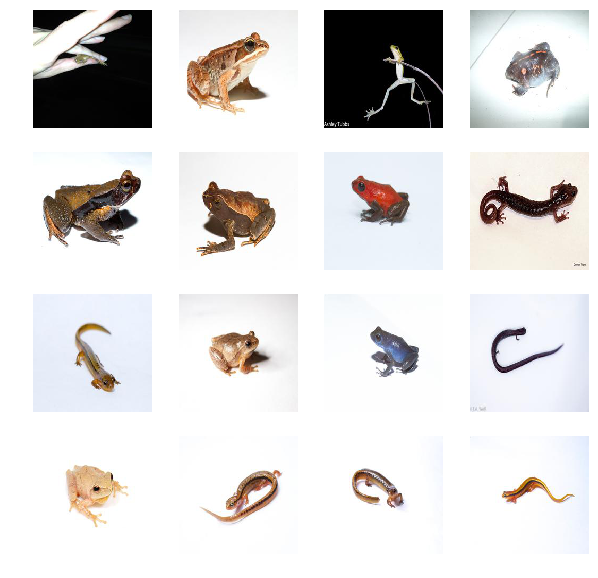

In [127]:
filt_43 = all_act[:,1,...]
l1_norms = np.array([filt_43[i].norm(p=1) for i in range(8161)])
plt.figure(figsize=(10,10))
for i, idx in enumerate(np.argsort(l1_norms)[-16:]):
    plt.subplot(4,4,i+1)
    plt.imshow(PIL.Image.open(trainset.imgs[idx][0]))
    plt.axis('off')

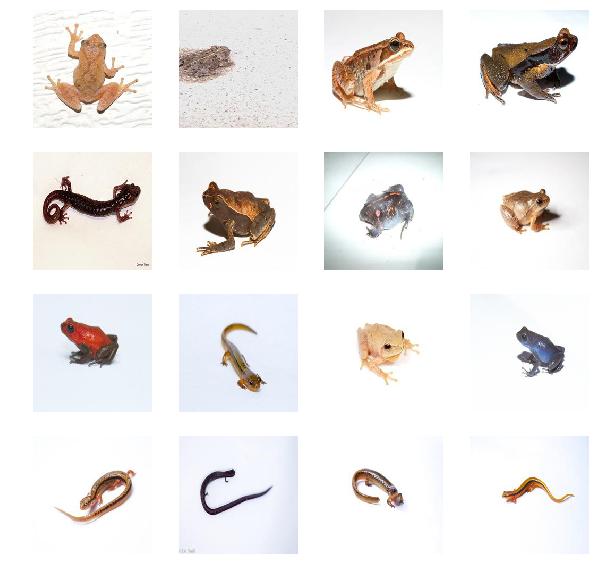

In [128]:
filt_23 = all_act[:,2,...]
l1_norms = np.array([filt_23[i].norm(p=1) for i in range(8161)])
plt.figure(figsize=(10,10))
for i, idx in enumerate(np.argsort(l1_norms)[-16:]):
    plt.subplot(4,4,i+1)
    plt.imshow(PIL.Image.open(trainset.imgs[idx][0]))
    plt.axis('off')

In [10]:
resnet = resnet.eval().cuda()

In [43]:
from util import preprocess_image, recreate_image
def get_blank_img():
    return preprocess_image(np.random.randn(100,100, 3))

In [44]:
childs = list(resnet.children())

In [45]:
# to_conv = nn.Sequential(
#     *(childs[:5] 
#       + list(childs[5].children())[:2] 
#       + [list(childs[5].children())[2].conv1]))

In [46]:
to_conv = resnet.conv1

In [53]:
img = get_blank_img()
filt = 4
eps = 1e-8
for i in range(20):    
    res = to_conv(img)[0,filt]
    objective = res.mean() 
    objective.backward()
    img.grad /= img.grad.std() + eps
    img.data += img.grad.data
    img = blur(img, 15/(i+1), 12/(i+1))

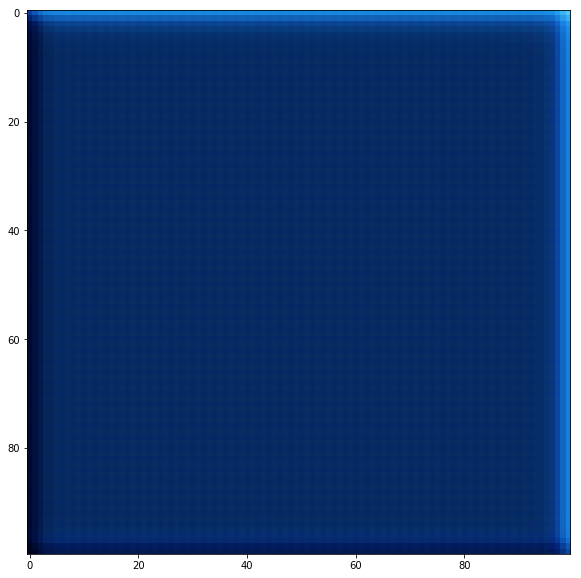

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(recreate_image(img))

In [23]:
def blur(img, sigma, c_sigma):
    out = recreate_image(img)
    out = gaussian_filter(out, [sigma, sigma, c_sigma])
#     out = cv2.bilateralFilter(out, 9, sigma, sigma)
    return preprocess_image(out)

In [13]:
import cv2

In [16]:
im = recreate_image(img)

In [67]:
cv2.bilateralFilter?

Docstring:
bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]]) -> dst
.   @brief Applies the bilateral filter to an image.
.   
.   The function applies bilateral filtering to the input image, as described in
.   http://www.dai.ed.ac.uk/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html
.   bilateralFilter can reduce unwanted noise very well while keeping edges fairly sharp. However, it is
.   very slow compared to most filters.
.   
.   _Sigma values_: For simplicity, you can set the 2 sigma values to be the same. If they are small (\<
.   10), the filter will not have much effect, whereas if they are large (\> 150), they will have a very
.   strong effect, making the image look "cartoonish".
.   
.   _Filter size_: Large filters (d \> 5) are very slow, so it is recommended to use d=5 for real-time
.   applications, and perhaps d=9 for offline applications that need heavy noise filtering.
.   
.   This filter does not work inplace.
.   @param src Source 8-bit or